In [39]:
import pandas as pd
import pyspark.sql.functions as f
from functools import reduce
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ExcelToSpark1").getOrCreate()
file1_pd = pd.read_csv("fl1.csv")
file2_pd = pd.read_csv("fl2.csv")

file1_spark = spark.createDataFrame(file1_pd)
file2_spark = spark.createDataFrame(file2_pd)

df_joined = file1_spark.join(file2_spark, on='KEY', how='left')
df_joined.printSchema()
df_joined.show(10)

root
 |-- KEY: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- TITLE_COMPL: double (nullable = true)
 |-- PROSP3_MEASURE: string (nullable = true)
 |-- FREQ: string (nullable = true)
 |-- S_NCA: string (nullable = true)
 |-- PROSP3_SECURITIES_TYPE: string (nullable = true)
 |-- MTR: string (nullable = true)
 |-- CURR_ISSNC: string (nullable = true)
 |-- PROSP3_OFFER_TYPE: string (nullable = true)
 |-- PROSP3_DOCUMENT_TYPE: string (nullable = true)
 |-- SEC_TYPE_CFI: string (nullable = true)
 |-- ISSUER_COU: string (nullable = true)
 |-- ISSUER_SECTOR: string (nullable = true)
 |-- PROSP3_PRSP_TYPE: string (nullable = true)
 |-- PROSP3_SME_CAT_TYPE: string (nullable = true)
 |-- PROSP3_PSSP: string (nullable = true)
 |-- PROSP3_VENUE: string (nullable = true)
 |-- PROSP3_LNGG: string (nullable = true)
 |-- MV: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- TIME_PERIOD: string (nullable = true)
 |-- PK: double (nullable = true)
 |-- OBS_VALUE: doubl

25/04/21 17:33:06 WARN TaskSetManager: Stage 22 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+-----

In [40]:
def parse_quarters(date_str):
    """
    Parses a date string in the format 'YYYY-QX' and returns the corresponding
    datetime object.
    """
    try:
        year_str, q_str2 = date_str.split('-Q')
        year = int(year_str)
        quarter = int(q_str2)
        month = (quarter - 1)*3 + 1

        return pd.Timestamp(year=year, month=month, day=1)
    except:
        return pd.NaT

In [41]:
df_joined = df_joined.toPandas()
df_joined['quarter_date'] = df_joined['TIME_PERIOD'].apply(parse_quarters)
df_joined = spark.createDataFrame(df_joined)
df_joined.show(10)

25/04/21 17:33:07 WARN TaskSetManager: Stage 27 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/21 17:33:17 WARN TaskSetManager: Stage 31 contains a task of very large size (4847 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+------------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+-------------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|     ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|       quarter_date|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+------------------+----------------+-----------

25/04/21 17:33:21 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 31 (TID 191): Attempting to kill Python Worker


In [42]:


def add_outlier_thresholds(
    data,
    numbercol,
    groupbycols=None,
    showstats=False,
    use_logs=False
):
    """
    Flags outliers in the specified numeric column based on being above
    the group-level median + 3 or 4 standard deviations.

    Parameters:
    - data: Spark DataFrame
    - numbercol: str, column to evaluate
    - groupbycols: list of str, columns to group by
    - showstats: bool, print number of outliers
    - use_logs: bool, apply log to the column before comparison
    """
    if groupbycols is None:
        groupbycols = []

    col3sd = f"{numbercol}_3sd"
    col4sd = f"{numbercol}_4sd"

    # Compute median and stddev per group
    stats_df = (
        data.groupBy(groupbycols)
        .agg(
            f.expr(f'percentile_approx({numbercol}, 0.5)').alias('median'),
            f.stddev(numbercol).alias('stddev')
        )
        .withColumn('threshold_3sd', f.col('median') + 3 * f.col('stddev'))
        .withColumn('threshold_4sd', f.col('median') + 4 * f.col('stddev'))
    )

    # Join stats back to data
    if groupbycols:
        join_condition = reduce(
            lambda x, y: x & y,
            [f.col(f"data.{col}") == f.col(f"stats.{col}") for col in groupbycols]
        )

        data = (
            data.alias("data")
            .join(stats_df.alias("stats"), on=join_condition, how="left")
        )
    else:
        data = (
            data.withColumn('dummykey', f.lit(1))
            .join(stats_df.withColumn('dummykey', f.lit(1)), on='dummykey', how='left')
            .drop('dummykey')
        )

    # Flag outliers
    if use_logs:
        data = data.withColumn(
            col3sd, f.when(f.log(f.abs(f.col(numbercol))) > f.col('threshold_3sd'), True).otherwise(False)
        ).withColumn(
            col4sd, f.when(f.log(f.abs(f.col(numbercol))) > f.col('threshold_4sd'), True).otherwise(False)
        )
    else:
        data = data.withColumn(
            col3sd, f.when(f.col(numbercol) > f.col('threshold_3sd'), True).otherwise(False)
        ).withColumn(
            col4sd, f.when(f.col(numbercol) > f.col('threshold_4sd'), True).otherwise(False)
        )

    # Show stats
    if showstats:
        count_3sd = data.filter(f.col(col3sd)).count()
        count_4sd = data.filter(f.col(col4sd)).count()
        print(f"[3SD OUTLIERS] {numbercol}: {count_3sd}")
        print(f"[4SD OUTLIERS] {numbercol}: {count_4sd}")

    return data.drop('median', 'stddev', 'threshold_3sd', 'threshold_4sd')

In [43]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import pyspark.sql.functions as f  # make sure you have this import

def melisa_outliers(
    spark_df,
    mode='thresholds',
    numbercol='OBS_VALUE',
    groupbycols=None,
    showstats=False,
    use_logs=False,
    min_filter=None,
    min_date=None,          # e.g. '2023-01-01'
    feature_cols=None
):
    if groupbycols is None:
        groupbycols = []

    # 1) Convert TIME_PERIOD -> real date for filtering
    def parse_quarters(date_str):
        try:
            y, q = date_str.split('-Q')
            m = (int(q)-1)*3 + 1
            return pd.Timestamp(year=int(y), month=m, day=1)
        except:
            return pd.NaT

    # Convert Spark -> pandas
    df_pd = spark_df.toPandas()
    df_pd['quarter_date'] = df_pd['TIME_PERIOD'].apply(parse_quarters)

    # 2) Apply min_date and min_filter
    if min_date is not None:
        cutoff = pd.to_datetime(min_date)
        df_pd = df_pd[df_pd['quarter_date'] >= cutoff]
    if min_filter is not None:
        df_pd = df_pd[df_pd[numbercol] >= min_filter]

    if mode == 'random_forest_regressor':
        # 3) Figure out features
        if feature_cols is None:
            numeric = df_pd.select_dtypes(include=['float','int']).columns.tolist()
            feature_cols = [c for c in numeric if c != numbercol]

        # Helper to train & flag per group
        def process_group(grp):
            if grp.shape[0] < 10:
                grp['rfr_outlier'] = False
                return grp

            X = grp[feature_cols]
            y = grp[numbercol]
            model = RandomForestRegressor(n_estimators=50, random_state=42)
            model.fit(X, y)

            grp['pred_rfr']      = model.predict(X)
            grp['residual_rfr']  = grp[numbercol] - grp['pred_rfr']
            sd = grp['residual_rfr'].std()
            thresh = 4 * sd

            grp['rfr_outlier'] = grp['residual_rfr'].abs() > thresh
            return grp

        # 4) Apply per‐group (or once if no grouping)
        if groupbycols:
            df_out = (
                df_pd
                .groupby(groupbycols, group_keys=False)
                .apply(process_group)
                .reset_index(drop=True)
            )
        else:
            df_out = process_group(df_pd)

        if showstats:
            print(df_out['rfr_outlier'].value_counts())

        # 5) Anything under min_filter must be False
        if min_filter is not None:
            df_out.loc[df_out[numbercol] < min_filter, 'rfr_outlier'] = False

        return spark.createDataFrame(df_out)

    elif mode == 'thresholds':
        # apply the existing threshold logic
        df_thresh = spark_df
        if min_filter is not None:
            df_thresh = df_thresh.filter(f.col(numbercol) >= min_filter)
        if min_date is not None:
            # make sure quarter_date column exists as date
            df_thresh = df_thresh.withColumn(
                'quarter_date',
                f.to_date(f.col('TIME_PERIOD').substr(1,4).cast('int').cast('string')  # crude: extract year; adjust if you have quarter_date as a column
            )).filter(f.col('quarter_date') >= f.lit(min_date))

        # run your threshold outlier function, which gives back only the key cols + value + flag
        outliers_only = add_outlier_thresholds(
            data=df_thresh,
            numbercol=numbercol,
            groupbycols=groupbycols,
            showstats=showstats,
            use_logs=use_logs
        )

        # now join back to the original spark_df on the grouping keys + TIME_PERIOD + numbercol
        join_keys = groupbycols + ['TIME_PERIOD', numbercol]
        full_with_flags = spark_df.join(
            outliers_only.select(*join_keys, 'is_outlier'),
            on=join_keys,
            how='left'
        ).withColumn(
            'is_outlier',
            f.coalesce(f.col('is_outlier'), f.lit(False))
        )

        return full_with_flags

    else:
        raise ValueError(f"Unknown mode: {mode}")

In [44]:
a = melisa_outliers(
    spark_df=df_joined,
    mode='random_forest_regressor',
    numbercol='OBS_VALUE',
    groupbycols=['PROSP3_SME_CAT_TYPE', 'SEC_TYPE_CFI'],
    showstats=True,
    use_logs=False,
    min_filter=0,
    min_date=None,
    feature_cols=['OBS_VALUE']
)

25/04/21 17:33:21 WARN TaskSetManager: Stage 32 contains a task of very large size (4847 KiB). The maximum recommended task size is 1000 KiB.
/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_60303/3970429507.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(process_group)


rfr_outlier
False    151420
True        608
Name: count, dtype: int64


25/04/21 17:33:39 WARN TaskSetManager: Stage 33 contains a task of very large size (5094 KiB). The maximum recommended task size is 1000 KiB.


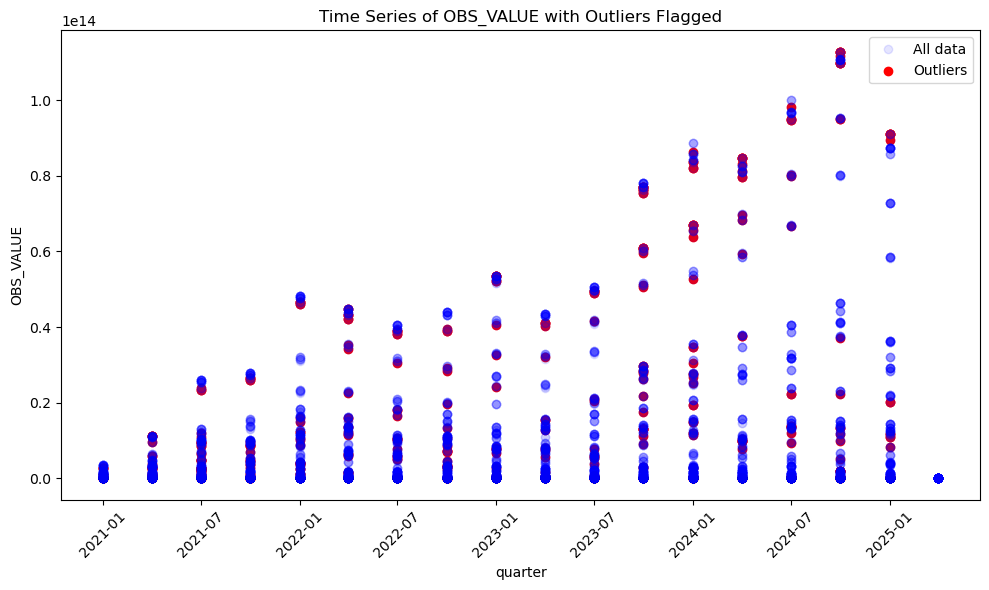

In [45]:
import matplotlib.pyplot as plt

pdf_out = a.toPandas()
#pdf_outliers = pdf_out[pdf_out['OBS_VALUE_4sd'] == True]
pdf_outliers = pdf_out[pdf_out['rfr_outlier'] == True]
plt.figure(figsize=(10, 6))

plt.plot(
    pdf_out['quarter_date'],
    pdf_out['OBS_VALUE'],
    marker='o',
    linestyle='',
    color='blue',
    alpha=0.1,
    label='All data'
)

plt.scatter(
    pdf_outliers['quarter_date'],
    pdf_outliers['OBS_VALUE'],
    color='red',
    label='Outliers'
)

plt.xlabel('quarter')
plt.ylabel('OBS_VALUE')
plt.title('Time Series of OBS_VALUE with Outliers Flagged')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
a.show(10)

+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+------------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+-------------------+--------------+-------------------+-----------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|     ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|       quarter_date|      pred_rfr|       residual_rfr|rfr_outlier|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+----------------

25/04/21 17:33:48 WARN TaskSetManager: Stage 34 contains a task of very large size (5094 KiB). The maximum recommended task size is 1000 KiB.


25/04/21 17:33:48 WARN TaskSetManager: Stage 35 contains a task of very large size (5094 KiB). The maximum recommended task size is 1000 KiB.


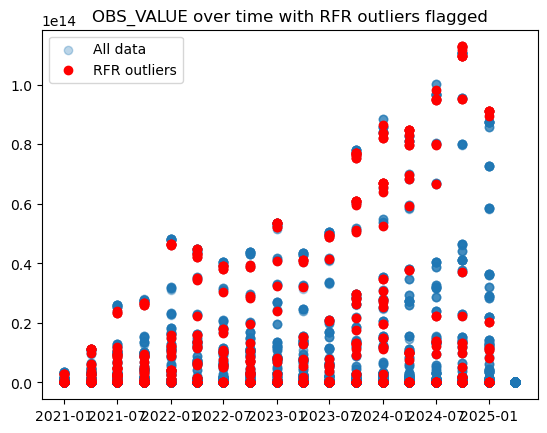

In [47]:
import matplotlib.pyplot as plt

a = a.toPandas()

plt.scatter(a['quarter_date'], a['OBS_VALUE'], alpha=0.3, label='All data')
out = a[a['rfr_outlier']]
plt.scatter(out['quarter_date'], out['OBS_VALUE'], color='red', label='RFR outliers')
plt.legend()
plt.title('OBS_VALUE over time with RFR outliers flagged')
plt.show()

In [48]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# 1) parse your quarter into a real date
parse_q = F.expr("""
  to_date(
    concat(
      split(TIME_PERIOD, '-Q')[0],
      '-',
      (cast(split(TIME_PERIOD, '-Q')[1] as int)-1)*3+1,
      '-01'
    )
  )
""")

df2 = df_joined \
  .withColumn('quarter_date', parse_q)

# 2) define a window per country+CFI, ordered by date
w = Window.partitionBy('S_NCA','SEC_TYPE_CFI') \
          .orderBy('quarter_date')

# 3) add one‑quarter lag
df2 = df2.withColumn('lag1_obs', F.lag('OBS_VALUE').over(w))

# 4) add a numeric time feature
df2 = df2.withColumn('time_index',
    F.year('quarter_date')*10 + ((F.quarter('quarter_date')-1))
)

# drop the first row per group (where lag1_obs is null)
df2 = df2.filter(F.col('lag1_obs').isNotNull())

In [49]:
e = melisa_outliers(
    spark_df    = df2,
    mode        = 'random_forest_regressor',
    numbercol   = 'OBS_VALUE',
    groupbycols = ['S_NCA','SEC_TYPE_CFI'],
    showstats   = True,
    min_filter  = 0,
    feature_cols= ['lag1_obs','time_index']
)

25/04/21 17:33:51 WARN TaskSetManager: Stage 36 contains a task of very large size (4847 KiB). The maximum recommended task size is 1000 KiB.
/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_60303/3970429507.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(process_group)


rfr_outlier
False    149525
True       1803
Name: count, dtype: int64


25/04/21 17:34:19 WARN TaskSetManager: Stage 39 contains a task of very large size (5301 KiB). The maximum recommended task size is 1000 KiB.


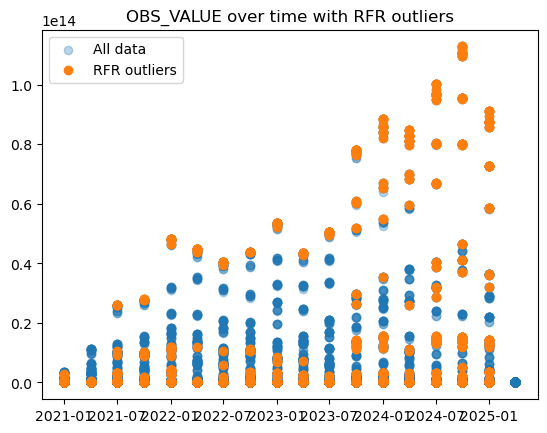

In [50]:
pdf = e.select('quarter_date','OBS_VALUE','rfr_outlier').toPandas()

plt.scatter(pdf['quarter_date'], pdf['OBS_VALUE'], alpha=0.3, label='All data')
o = pdf[pdf['rfr_outlier']]
plt.scatter(o['quarter_date'], o['OBS_VALUE'], label='RFR outliers')
plt.legend(); plt.title('OBS_VALUE over time with RFR outliers')
plt.show()

In [62]:
# Select only the columns you need
pdf = (
    e
    .select('KEY','TIME_PERIOD', 'S_NCA', 'SEC_TYPE_CFI',
            'OBS_VALUE','quarter_date', 'rfr_outlier')
    .toPandas()
)

25/04/21 17:35:11 WARN TaskSetManager: Stage 41 contains a task of very large size (5301 KiB). The maximum recommended task size is 1000 KiB.


In [63]:
pdf['S_NCA'].value_counts()

S_NCA
[A6] EEA30             16682
[A1] World             16682
[V5] EU27              16176
[I8] EA19              14422
[LU] Luxembourg         8950
[IE] Ireland            7992
[K0] EU not in EA19     7283
[DE] Germany            6021
[SE] Sweden             5352
[FR] France             4707
[A0] EEA3               3989
[NL] Netherlands        3956
[AT] Austria            3924
[IT] Italy              2800
[NO] Norway             2600
[ES] Spain              2392
[BE] Belgium            2316
[LI] Liechtenstein      2260
[CZ] Czechia            2007
[PL] Poland             1877
[SK] Slovakia           1859
[BG] Bulgaria           1747
[DK] Denmark            1736
[FI] Finland            1643
[IS] Iceland            1495
[MT] Malta              1414
[GR] Greece             1373
[LV] Latvia             1321
[RO] Romania            1261
[PT] Portugal           1246
[HU] Hungary             919
[EE] Estonia             885
[HR] Croatia             746
[LT] Lithuania           666
[SI] Slo

In [64]:
pdf[(pdf['S_NCA'] == '[DE] Germany') & (pdf['rfr_outlier'] == True)].groupby('SEC_TYPE_CFI')['rfr_outlier'].sum().loc[lambda s: s>0]

SEC_TYPE_CFI
Z                                                9
[DE] Structured debt (no capital protection)     6
[DM] Other debt                                  3
[DS] Structured debt (capital protection)        1
[DT] MTN                                         2
[D] Debt                                         2
[ES] Shares                                      3
[EY] Structured instruments (participation)      3
[E] Equity                                       6
[RF] Mini-future certificates                    3
[RW] Warrants                                    3
[R] Entitlement (rights)                        11
[SCRT] Securities                                5
[ZALL] All records if applicable                 5
[ZNAV] CFI not available                         3
Name: rfr_outlier, dtype: int64

In [83]:
sub = pdf[
    (pdf['S_NCA']   == '[DE] Germany') &
    (pdf['SEC_TYPE_CFI'] == '[DM] Other debt')
]

In [84]:
sub

,KEY,TIME_PERIOD,S_NCA,SEC_TYPE_CFI,OBS_VALUE,quarter_date,rfr_outlier,inherited_outlier
96715,PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.S12.Z.Z.Z...,2021-Q1,[DE] Germany,[DM] Other debt,14.0,2021-01-01,False,True
96716,PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.ZALL.Z.Z....,2021-Q1,[DE] Germany,[DM] Other debt,14.0,2021-01-01,False,True
96717,PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.A1_Z.Z.Z.Z...,2021-Q1,[DE] Germany,[DM] Other debt,1.0,2021-01-01,False,True
96718,PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.A6.Z.Z.Z.Z...,2021-Q2,[DE] Germany,[DM] Other debt,3.0,2021-04-01,False,True
96719,PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.DE.Z.Z.Z.Z...,2021-Q2,[DE] Germany,[DM] Other debt,3.0,2021-04-01,False,True
...,...,...,...,...,...,...,...,...
96914,PROSP3.MV.Q.DE.Z.Z.Z.Z.Z.DM.Z.S11.Z.Z.Z.Z.Z.Z,2025-Q1,[DE] Germany,[DM] Other debt,57357036.0,2025-01-01,False,True
96915,PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.S12.Z.Z.Z...,2025-Q1,[DE] Germany,[DM] Other debt,21.0,2025-01-01,False,True
96916,PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.A1.Z.Z.Z.Z...,2025-Q1,[DE] Germany,[DM] Other debt,2.0,2025-01-01,False,True
96917,PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.S11.Z.Z.Z...,2025-Q1,[DE] Germany,[DM] Other debt,8.0,2025-01-01,False,True


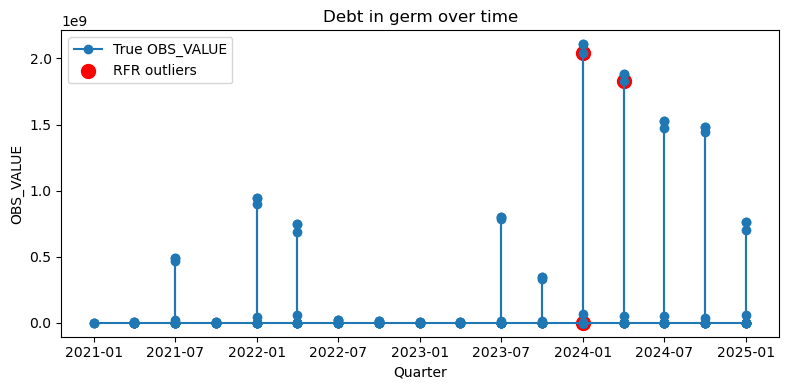

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(
    sub['quarter_date'],
    sub['OBS_VALUE'],
    '-o',
    label='True OBS_VALUE'
)

out = sub[sub['rfr_outlier']]
plt.scatter(
    out['quarter_date'],
    out['OBS_VALUE'],
    s=100,
    color='red',
    label='RFR outliers'
)

plt.title("Debt in germ over time")
plt.xlabel("Quarter")
plt.ylabel("OBS_VALUE")
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
map = pd.read_excel('Country Mapping.xlsx')

In [69]:
map

,CODE,DIRECT_PARENT,LEVEL_PARENT,ORDER,CODE_DESCRIPTION
0,Z,NaN,0,NaN,Filter not applied for location
1,ZNAV,Z,1,NaN,Country not available
2,A1,Z,1,NaN,World
3,A1_Z,A1,2,NaN,World - Undetermined
4,A1_TRNS,A1,2,NaN,World - International organisation
...,...,...,...,...,...
292,EH,UN015,5,NaN,Western Sahara
293,YE,UN202,5,NaN,Yemen
294,ZM,UN202,5,NaN,Zambia
295,ZW,UN202,5,NaN,Zimbabwe


In [70]:
parent_map = dict(zip(map['CODE'], map['DIRECT_PARENT']))
parent_map

{'Z': nan,
 'ZNAV': 'Z',
 'A1': 'Z',
 'A1_Z': 'A1',
 'A1_TRNS': 'A1',
 'A1_OTHR': 'A1',
 'A6': 'A1',
 'A6_Z': 'A6',
 'A6_TRNS': 'A6',
 'A6_OTHR': 'A6',
 'A0': 'A6',
 'V5': 'A6',
 'V5_Z': 'V5',
 'V5_TRNS': 'V5',
 'K0': 'V5',
 'I8': 'V5',
 'I8_Z': 'I8',
 'I8_TRNS': 'I8',
 'I8_OTHR': 'I8',
 'ROW': 'A1',
 'E2': 'ROW',
 'UN002': 'ROW',
 'UN015': 'UN002',
 'UN017': 'UN002',
 'UN018': 'UN002',
 'UN202': 'UN002',
 'UN011': 'UN202',
 'UN014': 'UN202',
 'UN009': 'ROW',
 'UN053': 'UN009',
 'UN057': 'UN009',
 'UN061': 'UN009',
 'UN010': 'ROW',
 'UN019': 'ROW',
 'UN021': 'UN019',
 'UN419': 'UN019',
 'UN005': 'UN419',
 'UN013': 'UN419',
 'UN029': 'UN419',
 'UN142': 'ROW',
 'UN030': 'UN142',
 'UN034': 'UN142',
 'UN035': 'UN142',
 'UN143': 'UN142',
 'UN145': 'UN142',
 'IS': 'A0',
 'LI': 'A0',
 'NO': 'A0',
 'GB': 'E2',
 'MK': 'E2',
 'AX': 'E2',
 'AL': 'E2',
 'AD': 'E2',
 'BY': 'E2',
 'BA': 'E2',
 'GI': 'E2',
 'GG': 'E2',
 'VA': 'E2',
 'IM': 'E2',
 'JE': 'E2',
 'XK': 'E2',
 'MD': 'E2',
 'MC': 'E2',
 'ME

In [71]:
pdf

,KEY,TIME_PERIOD,S_NCA,SEC_TYPE_CFI,OBS_VALUE,quarter_date,rfr_outlier
0,PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z...,2023-Q3,[A0] EEA3,[ED] DR equities,1.0,2023-07-01,False
1,PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z....,2023-Q3,[A0] EEA3,[ED] DR equities,1.0,2023-07-01,False
2,PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.ROW.Z.Z.Z....,2023-Q3,[A0] EEA3,[ED] DR equities,1.0,2023-07-01,False
3,PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z.Z.Z,2023-Q3,[A0] EEA3,[ED] DR equities,1834864.6,2023-07-01,False
4,PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.UN019.Z.Z....,2023-Q3,[A0] EEA3,[ED] DR equities,1.0,2023-07-01,False
...,...,...,...,...,...,...,...
151323,PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.ROW.Z.Z....,2025-Q2,[V5] EU27,[ZALL] All records if applicable,1.0,2025-04-01,False
151324,PROSP3.NUM_INSTR.Q.V5.Z.Z.Z.Z.Z.ZALL.Z.Z.Z.Z.Z...,2025-Q2,[V5] EU27,[ZALL] All records if applicable,24.0,2025-04-01,False
151325,PROSP3.NUM_INSTR.Q.V5.Z.Z.Z.Z.Z.ZALL.Z.ZALL.Z....,2025-Q2,[V5] EU27,[ZALL] All records if applicable,24.0,2025-04-01,False
151326,PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.A1.Z.Z.Z...,2025-Q2,[V5] EU27,[ZALL] All records if applicable,4.0,2025-04-01,False


In [ ]:
import pandas as pd

# 0) (re)extract the raw code if you haven’t yet
pdf['code'] = pdf['S_NCA'].str.extract(r'\[([^\]]+)\]')

# 1) Build parent_map
parent_map = dict(zip(map['CODE'], map['DIRECT_PARENT']))

# 2) Define a helper to walk up from any code to its ancestors
def get_ancestors(code):
    anc = []
    p = parent_map.get(code)
    while p and pd.notna(p):
        anc.append(p)
        p = parent_map.get(p)
    return anc

# 3) Build a small DataFrame of all (TIME_PERIOD, SEC_TYPE_CFI, code, ancestors)
#    for only the rows the RFR actually flagged
flagged = pdf.loc[pdf['rfr_outlier'], ['TIME_PERIOD','SEC_TYPE_CFI','code']].copy()
flagged['ancestors'] = flagged['code'].map(get_ancestors)

# 4) Explode that list so each ancestor is its own row
flagged_expanded = (
    flagged
    .explode('ancestors')
    .dropna(subset=['ancestors'])
    .rename(columns={'ancestors':'ancestor_code'})
    # now columns: TIME_PERIOD, SEC_TYPE_CFI, code, ancestor_code
)

# 5) Initialize the new flag
pdf['inherited_outlier'] = False

# 6) Any row whose (TIME_PERIOD, SEC_TYPE_CFI, code) matches a flagged ancestor
#    becomes inherited_outlier=True
mask = pd.merge(
    pdf,
    flagged_expanded[['TIME_PERIOD','SEC_TYPE_CFI','ancestor_code']],
    left_on  = ['TIME_PERIOD','SEC_TYPE_CFI','code'],
    right_on = ['TIME_PERIOD','SEC_TYPE_CFI','ancestor_code'],
    how      = 'left',
    indicator= '_hit'
)['_hit'] == 'both'

pdf.loc[mask, 'inherited_outlier'] = True

# 7) (Optional) clean up
pdf = pdf.drop(columns=['code'])

# 8) Look at your two flags
print(pdf[['KEY','TIME_PERIOD','S_NCA','SEC_TYPE_CFI','OBS_VALUE',
           'rfr_outlier','inherited_outlier']].head(10))

                                                 KEY TIME_PERIOD      S_NCA  \
0  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z...     2023-Q3  [A0] EEA3   
1  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z....     2023-Q3  [A0] EEA3   
2  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.ROW.Z.Z.Z....     2023-Q3  [A0] EEA3   
3        PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z.Z.Z     2023-Q3  [A0] EEA3   
4  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.UN019.Z.Z....     2023-Q3  [A0] EEA3   
5     PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z.Z.Z.Z.Z     2023-Q3  [A0] EEA3   
6  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.A1.Z.Z.Z.Z...     2024-Q1  [A0] EEA3   
7  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z...     2024-Q1  [A0] EEA3   
8  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z....     2024-Q1  [A0] EEA3   
9  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.ROW.Z.Z.Z....     2024-Q1  [A0] EEA3   

       SEC_TYPE_CFI  OBS_VALUE  rfr_outlier  inherited_outlier  
0  [ED] DR equities        1.0        False              False  


In [73]:
pdf[pdf['inherited_outlier']==True]

,KEY,TIME_PERIOD,S_NCA,SEC_TYPE_CFI,OBS_VALUE,quarter_date,rfr_outlier,inherited_outlier
19,PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.CZ.Z.Z.Z.Z....,2021-Q1,[A1] World,Z,35.0,2021-01-01,False,True
20,PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.E2.Z.Z.Z.Z....,2021-Q1,[A1] World,Z,41.0,2021-01-01,False,True
21,PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.HR.Z.Z.Z.Z....,2021-Q1,[A1] World,Z,1.0,2021-01-01,False,True
22,PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.SE.Z.Z.Z.Z....,2021-Q1,[A1] World,Z,108.0,2021-01-01,False,True
23,PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.UN142.Z.Z.Z...,2021-Q1,[A1] World,Z,17.0,2021-01-01,False,True
...,...,...,...,...,...,...,...,...
151323,PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.ROW.Z.Z....,2025-Q2,[V5] EU27,[ZALL] All records if applicable,1.0,2025-04-01,False,True
151324,PROSP3.NUM_INSTR.Q.V5.Z.Z.Z.Z.Z.ZALL.Z.Z.Z.Z.Z...,2025-Q2,[V5] EU27,[ZALL] All records if applicable,24.0,2025-04-01,False,True
151325,PROSP3.NUM_INSTR.Q.V5.Z.Z.Z.Z.Z.ZALL.Z.ZALL.Z....,2025-Q2,[V5] EU27,[ZALL] All records if applicable,24.0,2025-04-01,False,True
151326,PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.A1.Z.Z.Z...,2025-Q2,[V5] EU27,[ZALL] All records if applicable,4.0,2025-04-01,False,True


In [ ]:
# okay so this makes sense. but i still need to be careful about the way these are flagged.

The way the code is structured right now, the whole hierarchy is flagged if a nember is flagged. Maybe this is not a correct approach bcs world gets flagged?? maybe i should flag only direct parentship??


In [ ]:
# If i want to mao to only the immediate parent:
'''
flagged = pdf.loc[pdf['rfr_outlier'], ['TIME_PERIOD','SEC_TYPE_CFI','code']].copy()
flagged['parent'] = flagged['code'].map(parent_map)          # only one level up
flagged_expanded = flagged.dropna(subset=['parent']).rename(
    columns={'parent':'ancestor_code'}
)
mask = pd.merge(
    pdf,
    flagged_expanded[['TIME_PERIOD','SEC_TYPE_CFI','ancestor_code']],
    left_on  = ['TIME_PERIOD','SEC_TYPE_CFI','code'],
    right_on = ['TIME_PERIOD','SEC_TYPE_CFI','ancestor_code'],
    how      = 'left',
    indicator= '_hit'
)['_hit'] == 'both'

pdf['inherited_outlier'] = False
pdf.loc[mask, 'inherited_outlier'] = True
'''

Ask Jordi abt the further granularity data to perform the actual time series analysis.

In [ ]:
pdf['quarter_date'].max()

Timestamp('2025-04-01 00:00:00')

In [ ]:
from skforecast.recursive import ForecasterRecursive
from sklearn.tree import DecisionTreeRegressor


train_start = pdf['quarter_date'].min()
train_end = '2024-09-01'
test_start = '2024-09-01'
test_end = pdf['quarter_date'].max()

df = pdf

df['quarter_date'] = pd.to_datetime(df['quarter_date'])

forecaster = ForecasterRecursive(
    regressor = DecisionTreeRegressor(random_state=123),
    lags      = 30
)

mask       = (df['quarter_date'] >= train_start) & (df['quarter_date'] <= train_end)
y_train    = df.loc[mask, 'OBS_VALUE']
forecaster.fit(y = y_train)

mask_test  = (df['quarter_date'] >= test_start) & (df['quarter_date'] <= test_end)
n_steps    = mask_test.sum()
predictions = forecaster.predict(steps = n_steps)


╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /opt/anaconda3/envs/datasci/lib/python3.12/site-packages/skforecast/utils/utils.py:1 │
│ 411                                                                                  │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has an unsupported index type (not pandas DatetimeIndex or             │
│ RangeIndex). The index will be replaced by a RangeIndex starting from 0 with a step  │
│ of 1. To avoid this warning, ensure that `last_window.index` is a DatetimeIndex with │
│ a frequency or a RangeIndex.                                                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /opt/anaconda3/envs/datasci/lib/python3.12/site-packages/skforecast/utils/utils.py:1 │
│ 468                                                                                  │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
import pmdarima as pm

train_mask = (df['quarter_date'] >= train_start) & (df['quarter_date'] <= train_end)
y_train    = df.loc[train_mask, 'OBS_VALUE']
arima = pm.AutoARIMA(seasonal=False)
arima.fit(y_train)
test_mask  = (df['quarter_date'] >= test_start) & (df['quarter_date'] <= test_end)
n_test     = test_mask.sum()
arima_train = arima.predict_in_sample()
#arima_test  = arima.predict(n_periods=n_test)

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_

TypeError: n_periods must be an int

25/04/21 23:48:55 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 281900 ms exceeds timeout 120000 ms
25/04/21 23:48:55 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/21 23:48:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
df.loc[test_start:test_end].plot(ax=ax, label = "Test")
predicted_test.plot(ax=ax, label = 'Predicted DT')
arima_test.plot(ax=ax, label = 'Predicted ARIMA')
ax.legend()